In [3]:
import pandas as pd
import numpy as np
import seaborn as sn
from suntime import Sun
import pytz
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor
import optuna
from scipy.stats import zscore
pd.set_option('display.float_format', lambda x: '%.8f' % x)

# Helper Functions

In [4]:
def datetime_index(dataframe):
    dataframe.columns = dataframe.columns.str.replace(' ', '')
    dataframe['Datetime'] = pd.to_datetime(dataframe['DateTime'])
    dataframe = dataframe.set_index(['Datetime'])
    del dataframe['DateTime']
    return dataframe

def fill_na(dataframe):
    dataframe['WWCode'] = dataframe['WWCode'].fillna(0).astype(int)
    return dataframe

def day_night(dataframe):

    coordinates = [40.239, 33.029] # Ankara
    dataframe['datetime_col'] = dataframe.index
    
    dataframe["Date"] = dataframe['datetime_col'].apply(pd.to_datetime).dt.date.apply(str)
    dataframe["Hour"] = dataframe['datetime_col'].apply(pd.to_datetime).dt.hour
    dataframe["Day_of_Week"] = dataframe['datetime_col'].apply(pd.to_datetime).dt.dayofweek
    dataframe["Quarter"] = dataframe['datetime_col'].apply(pd.to_datetime).dt.quarter
    dataframe["Month"] = dataframe['datetime_col'].apply(pd.to_datetime).dt.month
    dataframe["Year"] = dataframe['datetime_col'].apply(pd.to_datetime).dt.year
    dataframe["Day_of_Year"] = dataframe['datetime_col'].apply(pd.to_datetime).dt.dayofyear
    dataframe["Week"] = dataframe['datetime_col'].apply(pd.to_datetime).dt.week
    dataframe["Week_of_Year"] = dataframe['datetime_col'].apply(pd.to_datetime).dt.weekofyear
    
    sun = Sun(coordinates[0], coordinates[1])
    tz =pytz.timezone('Europe/Istanbul')
    dataframe["Day"]= dataframe[["Date","Hour"]].apply(lambda x : sun.get_local_sunrise_time(pd.to_datetime(x["Date"]).
                                                                date(),local_time_zone=tz).
                                         hour <= x["Hour"] <= sun.get_local_sunset_time(pd.to_datetime(x["Date"]).
                                                                date(),local_time_zone=tz).hour ,axis=1)
    dataframe = dataframe.drop(['Date', 'datetime_col'], axis = 1)
    return dataframe

def wwcode_encoder(dataframe):
    for index, row in dataframe.iterrows():
        if row['WWCode'] < 10:
            dataframe.loc[index, 'WWCode'] = 1
        elif row['WWCode'] < 20:
            dataframe.loc[index, 'WWCode'] = 2
        elif row['WWCode'] < 30:
            dataframe.loc[index, 'WWCode'] = 3
        elif row['WWCode'] < 40:
            dataframe.loc[index, 'WWCode'] = 4
        elif row['WWCode'] < 50:
            dataframe.loc[index, 'WWCode'] = 5
        elif row['WWCode'] < 60:
            dataframe.loc[index, 'WWCode'] = 6
        elif row['WWCode'] < 70:
            dataframe.loc[index, 'WWCode'] = 7
        elif row['WWCode'] < 80:
            dataframe.loc[index, 'WWCode'] = 8
        elif row['WWCode'] < 90:
            dataframe.loc[index, 'WWCode'] = 9
        elif row['WWCode'] < 100:
            dataframe.loc[index, 'WWCode'] = 10
    return dataframe
    
    
def season_encoder(dataframe):
    dataframe['Season'] = 0
    for index, row in dataframe.iterrows():
        if row['Month'] < 3 or row['Month'] == 12:
            dataframe.loc[index, 'Season'] = 1
        elif row['Month'] < 6:
            dataframe.loc[index, 'Season'] = 2
        elif row['Month'] < 9:
            dataframe.loc[index, 'Season'] = 3
        elif row['Month'] < 12:
            dataframe.loc[index, 'Season'] = 4
    return dataframe

def fig_plot():
    plt.figure(figsize = (10,15))
    plt.scatter(Y_test, pred_val)
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    
    
def objective(trial):
    learning_rate = trial.suggest_float("learning_rate", 1e-2, 0.25, log=True)
    reg_lambda = trial.suggest_loguniform("reg_lambda", 1e-8, 100.0)
    reg_alpha = trial.suggest_loguniform("reg_alpha", 1e-8, 100.0)
    subsample = trial.suggest_float("subsample", 0.1, 1.0)
    colsample_bytree = trial.suggest_float("colsample_bytree", 0.1, 1.0)
    max_depth = trial.suggest_int("max_depth", 1, 7)
    early_stopping_rounds = trial.suggest_int("early_stopping_rounds", 100, 500)
    n_estimators = trial.suggest_int("n_estimators", 0, 10000)
    
    model = XGBRegressor(
        random_state=50,
        tree_method="gpu_hist",
        gpu_id=0,
        predictor="gpu_predictor",
        n_estimators=n_estimators,
        learning_rate=learning_rate,
        reg_lambda=reg_lambda,
        reg_alpha=reg_alpha,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        max_depth=max_depth,
    )
    model.fit(
        X_train,
        Y_train,
        early_stopping_rounds=early_stopping_rounds,
        eval_set=[(X_test, Y_test)],
        verbose=1200,
    )
    preds_valid = model.predict(X_test)
    rmse = mean_squared_error(Y_test, preds_valid, squared=False)

    return rmse

# Data Extraction

In [5]:
submission = pd.read_csv('sample_submission.csv')
label = datetime_index(pd.read_csv('generation.csv', delimiter=';', decimal=','))
features = datetime_index(pd.read_csv('temperature.csv', delimiter=';', decimal=','))

In [6]:
x_train  = fill_na(features.loc['2019-01-01':'2021-11-30'])
x_test = day_night(fill_na(features.loc['2021-12-01':'2021-12-31']))
y_train  = label.loc['2019-01-01':'2021-11-30']

C:\Users\asus\AppData\Local\Temp/ipykernel_8644/2852319294.py:24: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  dataframe["Week"] = dataframe['datetime_col'].apply(pd.to_datetime).dt.week
C:\Users\asus\AppData\Local\Temp/ipykernel_8644/2852319294.py:25: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  dataframe["Week_of_Year"] = dataframe['datetime_col'].apply(pd.to_datetime).dt.weekofyear


In [7]:
df_train = day_night(pd.concat([ x_train, y_train], axis=1))

C:\Users\asus\AppData\Local\Temp/ipykernel_8644/2852319294.py:24: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  dataframe["Week"] = dataframe['datetime_col'].apply(pd.to_datetime).dt.week
C:\Users\asus\AppData\Local\Temp/ipykernel_8644/2852319294.py:25: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  dataframe["Week_of_Year"] = dataframe['datetime_col'].apply(pd.to_datetime).dt.weekofyear


### Preprocessing

In [8]:
df_train = wwcode_encoder(df_train)
df_train = season_encoder(df_train)

x_test = wwcode_encoder(x_test)
x_test = season_encoder(x_test)

In [7]:
# df_train.drop(['ComfortTemperature'], axis=1, inplace=True)
# x_test.drop(['ComfortTemperature'], axis=1, inplace=True)

In [8]:
# df_train

In [9]:
# df_train = pd.get_dummies(df_train, columns = ['WWCode'])
# x_test = pd.get_dummies(x_test, columns = ['WWCode'])

##### Z-Score

In [44]:
df_train['Zscore_SP'] = zscore(df_train.Generation)
df_train.Generation[(df_train.Zscore_SP >1.66 ) & (df_train.Season == 1)].describe()

count   163.00000000
mean    343.72080698
std      34.30352441
min     299.26237160
25%     313.42950815
50%     338.60805640
75%     367.81197795
max     424.67297670
Name: Generation, dtype: float64

In [28]:
winter = df_train[df_train.Season == 1]
winter.Generation.describe()

count   5760.00000000
mean      48.20699096
std       86.17018989
min        0.00000000
25%        0.00000800
50%        0.01720500
75%       60.33344525
max      424.67297670
Name: Generation, dtype: float64

In [47]:
drop_winter = winter[winter.Generation >= 300]
drop_winter

,AirTemperature,ComfortTemperature,RelativeHumidity,WindSpeed,WindDirection,WWCode,EffectiveCloudCover,Generation,Hour,Day_of_Week,Quarter,Month,Year,Day_of_Year,Week,Week_of_Year,Day,Season,Zscore_SP
Datetime,,,,,,,,,,,,,,,,,,,
2019-02-17 11:00:00,4.80000000,4.40000000,59.20000000,0.50000000,140.00000000,1,0.00000000,302.95961230,11,6,1,2,2019,48,7,7,True,1,1.68996154
2019-02-17 12:00:00,6.70000000,5.00000000,57.50000000,2.10000000,80.00000000,1,0.00000000,320.80278350,12,6,1,2,2019,48,7,7,True,1,1.83137463
2019-02-17 13:00:00,7.00000000,6.30000000,46.90000000,1.00000000,30.00000000,1,0.00000000,314.63090880,13,6,1,2,2019,48,7,7,True,1,1.78246047
2019-02-18 11:00:00,4.70000000,4.30000000,63.20000000,1.00000000,210.00000000,1,0.00000000,302.95677580,11,0,1,2,2019,49,8,8,True,1,1.68993906
2019-02-18 12:00:00,5.90000000,5.40000000,56.50000000,1.50000000,220.00000000,1,0.00000000,310.91019220,12,0,1,2,2019,49,8,8,True,1,1.75297254
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-02-27 14:00:00,11.90000000,10.90000000,38.80000000,1.50000000,180.00000000,1,0.00000000,377.57258900,14,5,1,2,2021,58,8,8,True,1,2.28129430
2021-02-27 15:00:00,12.90000000,11.80000000,35.80000000,1.00000000,140.00000000,1,0.00000000,305.76133830,15,5,1,2,2021,58,8,8,True,1,1.71216616
2021-02-28 10:00:00,5.00000000,4.60000000,64.20000000,1.00000000,230.00000000,1,0.00000000,309.58649620,10,6,1,2,2021,59,8,8,True,1,1.74248181


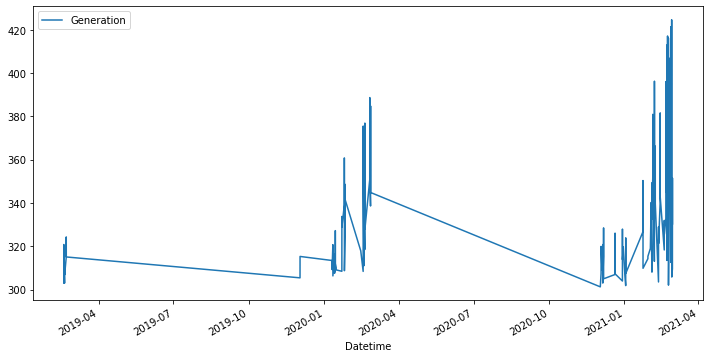

In [48]:
ax = drop_winter.plot(y='Generation', figsize=(12,6))

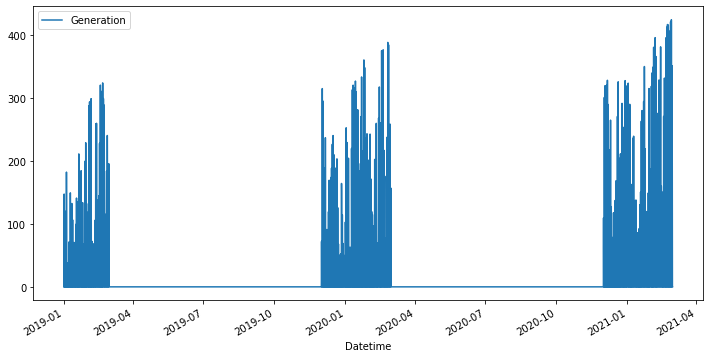

In [27]:
ax = winter.plot(y='Generation', figsize=(12,6))

In [49]:
df_train = df_train[~((df_train.Generation >= 300) & (df_train.Season == 1))]
df_train

,AirTemperature,ComfortTemperature,RelativeHumidity,WindSpeed,WindDirection,WWCode,EffectiveCloudCover,Generation,Hour,Day_of_Week,Quarter,Month,Year,Day_of_Year,Week,Week_of_Year,Day,Season,Zscore_SP
Datetime,,,,,,,,,,,,,,,,,,,
2019-01-01 00:00:00,-1.70000000,-6.10000000,75.30000000,3.60000000,60.00000000,2,6.30000000,0.00000000,0,1,1,1,2019,1,1,1,False,1,-0.71109456
2019-01-01 01:00:00,-1.80000000,-5.30000000,75.30000000,2.60000000,70.00000000,2,4.50000000,0.00000000,1,1,1,1,2019,1,1,1,False,1,-0.71109456
2019-01-01 02:00:00,-2.00000000,-6.00000000,74.70000000,3.10000000,80.00000000,2,5.50000000,0.00000800,2,1,1,1,2019,1,1,1,False,1,-0.71109449
2019-01-01 03:00:00,-1.90000000,-5.90000000,76.40000000,3.10000000,60.00000000,2,7.60000000,0.00000000,3,1,1,1,2019,1,1,1,False,1,-0.71109456
2019-01-01 04:00:00,-2.00000000,-7.10000000,76.40000000,4.60000000,60.00000000,2,6.50000000,0.00000800,4,1,1,1,2019,1,1,1,False,1,-0.71109449
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-11-30 19:00:00,7.10000000,5.20000000,76.80000000,3.10000000,220.00000000,3,6.00000000,0.00000000,19,1,4,11,2021,334,48,48,False,4,-0.71109456
2021-11-30 20:00:00,7.10000000,5.70000000,75.20000000,2.10000000,250.00000000,9,6.00000000,0.00000000,20,1,4,11,2021,334,48,48,False,4,-0.71109456
2021-11-30 21:00:00,5.80000000,3.10000000,83.40000000,4.10000000,280.00000000,9,7.00000000,0.00000000,21,1,4,11,2021,334,48,48,False,4,-0.71109456


##### Dataset no:1

In [50]:
X_train = df_train.loc['2019-01-01':'2021-10-31'].drop(['Generation'], axis=1)
X_test = df_train.loc['2021-10-01':'2021-11-30'].drop(['Generation'], axis=1)
Y_train = df_train.Generation.loc['2019-01-01':'2021-10-31']
Y_test = df_train.Generation.loc['2021-10-01':'2021-11-30']

##### Dataset no:2

In [51]:
# X_train = df_train.loc['2019-01-01':'2021-04-30'].drop(['Generation'], axis=1)
# X_test = df_train.loc['2021-05-01':'2021-11-30'].drop(['Generation'], axis=1)
# Y_train = df_train.Generation.loc['2019-01-01':'2021-04-30']
# Y_test = df_train.Generation.loc['2021-05-01':'2021-11-30']

# Model Training

### Optune

In [52]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=20)

[I 2022-03-01 11:12:29,857] A new study created in memory with name: no-name-af85af97-ae34-458a-84fe-deb5a526b703


[0]	validation_0-rmse:139.53819
[1200]	validation_0-rmse:3.35915
[2400]	validation_0-rmse:2.79327
[3600]	validation_0-rmse:2.44441
[4800]	validation_0-rmse:2.19330
[6000]	validation_0-rmse:2.01109
[7200]	validation_0-rmse:1.86551
[8400]	validation_0-rmse:1.74603
[9004]	validation_0-rmse:1.69744


[I 2022-03-01 11:13:03,540] Trial 0 finished with value: 1.6962415380900235 and parameters: {'learning_rate': 0.1556337453142432, 'reg_lambda': 0.004479986946975827, 'reg_alpha': 6.928012605496218e-05, 'subsample': 0.5326209569889867, 'colsample_bytree': 0.6226336076440085, 'max_depth': 1, 'early_stopping_rounds': 283, 'n_estimators': 9005}. Best is trial 0 with value: 1.6962415380900235.


[0]	validation_0-rmse:141.55870
[1200]	validation_0-rmse:3.36988
[2400]	validation_0-rmse:2.91785
[3600]	validation_0-rmse:2.72049
[4800]	validation_0-rmse:2.60111
[5429]	validation_0-rmse:2.56488


[I 2022-03-01 11:13:36,639] Trial 1 finished with value: 2.562046094508308 and parameters: {'learning_rate': 0.12993964492303203, 'reg_lambda': 0.002805554811064541, 'reg_alpha': 3.3859511400239355, 'subsample': 0.7069555261099717, 'colsample_bytree': 0.4069765516869499, 'max_depth': 4, 'early_stopping_rounds': 112, 'n_estimators': 8035}. Best is trial 0 with value: 1.6962415380900235.


[0]	validation_0-rmse:132.30250
[1086]	validation_0-rmse:1.84913


[I 2022-03-01 11:13:42,101] Trial 2 finished with value: 1.8485659061250734 and parameters: {'learning_rate': 0.13481865563589554, 'reg_lambda': 1.810586000290367, 'reg_alpha': 1.1876118438370986e-05, 'subsample': 0.5168013373904414, 'colsample_bytree': 0.7102641902045765, 'max_depth': 3, 'early_stopping_rounds': 356, 'n_estimators': 1087}. Best is trial 0 with value: 1.6962415380900235.


[0]	validation_0-rmse:149.34883
[1200]	validation_0-rmse:15.13549
[2400]	validation_0-rmse:7.78809
[3600]	validation_0-rmse:5.61328
[4800]	validation_0-rmse:4.67905
[5100]	validation_0-rmse:4.51343


[I 2022-03-01 11:14:00,465] Trial 3 finished with value: 4.513432385124558 and parameters: {'learning_rate': 0.014057764143694603, 'reg_lambda': 0.0017053462130816794, 'reg_alpha': 3.3748245047935485e-05, 'subsample': 0.7203739781429482, 'colsample_bytree': 0.3172202430822616, 'max_depth': 1, 'early_stopping_rounds': 333, 'n_estimators': 5101}. Best is trial 0 with value: 1.6962415380900235.


[0]	validation_0-rmse:148.73451
[1200]	validation_0-rmse:2.06061
[2400]	validation_0-rmse:1.39391
[3600]	validation_0-rmse:1.19225
[4800]	validation_0-rmse:1.09169
[5589]	validation_0-rmse:1.04579


[I 2022-03-01 11:14:24,625] Trial 4 finished with value: 1.0457243254612323 and parameters: {'learning_rate': 0.012971850234103787, 'reg_lambda': 6.458478205276792e-07, 'reg_alpha': 0.6878617314325361, 'subsample': 0.5314183885209738, 'colsample_bytree': 0.7998627507708023, 'max_depth': 2, 'early_stopping_rounds': 275, 'n_estimators': 5590}. Best is trial 4 with value: 1.0457243254612323.


[0]	validation_0-rmse:144.56343
[1200]	validation_0-rmse:11.27211
[2400]	validation_0-rmse:10.94031
[3600]	validation_0-rmse:10.83366
[4476]	validation_0-rmse:10.79924


[I 2022-03-01 11:15:41,165] Trial 5 finished with value: 10.797892210490943 and parameters: {'learning_rate': 0.15326664718639868, 'reg_lambda': 6.921103530423697e-06, 'reg_alpha': 3.0033252851899275, 'subsample': 0.7407390168323301, 'colsample_bytree': 0.17110421373835022, 'max_depth': 7, 'early_stopping_rounds': 336, 'n_estimators': 4477}. Best is trial 4 with value: 1.0457243254612323.


[0]	validation_0-rmse:149.27855
[1200]	validation_0-rmse:7.95308
[2400]	validation_0-rmse:5.99857
[3600]	validation_0-rmse:5.22804
[4800]	validation_0-rmse:4.80657
[6000]	validation_0-rmse:4.56724
[7200]	validation_0-rmse:4.42252
[7916]	validation_0-rmse:4.35692


[I 2022-03-01 11:17:16,619] Trial 6 finished with value: 4.356919107253486 and parameters: {'learning_rate': 0.016640845930688, 'reg_lambda': 1.0306244998486716e-08, 'reg_alpha': 5.725220104210864e-06, 'subsample': 0.565592430179317, 'colsample_bytree': 0.22615366950019072, 'max_depth': 6, 'early_stopping_rounds': 451, 'n_estimators': 7917}. Best is trial 4 with value: 1.0457243254612323.


[0]	validation_0-rmse:146.61609
[1200]	validation_0-rmse:3.10047
[2400]	validation_0-rmse:2.40068
[3600]	validation_0-rmse:2.14482
[4800]	validation_0-rmse:1.99190
[6000]	validation_0-rmse:1.89853
[6599]	validation_0-rmse:1.84590


[I 2022-03-01 11:17:47,985] Trial 7 finished with value: 1.8455814227392058 and parameters: {'learning_rate': 0.05846171456359441, 'reg_lambda': 2.894682850986479e-07, 'reg_alpha': 8.754835005250895, 'subsample': 0.25686497788410967, 'colsample_bytree': 0.41966772991965184, 'max_depth': 3, 'early_stopping_rounds': 319, 'n_estimators': 6600}. Best is trial 4 with value: 1.0457243254612323.


[0]	validation_0-rmse:142.33843
[864]	validation_0-rmse:8.72514


[I 2022-03-01 11:17:54,529] Trial 8 finished with value: 8.552537140093417 and parameters: {'learning_rate': 0.17620774581398452, 'reg_lambda': 0.007720901299397063, 'reg_alpha': 1.639086440154622e-05, 'subsample': 0.3468855874904626, 'colsample_bytree': 0.2346312964860806, 'max_depth': 5, 'early_stopping_rounds': 324, 'n_estimators': 5964}. Best is trial 4 with value: 1.0457243254612323.


[0]	validation_0-rmse:146.62868
[1200]	validation_0-rmse:4.06242
[2400]	validation_0-rmse:3.26907
[3121]	validation_0-rmse:3.02673


[I 2022-03-01 11:18:12,030] Trial 9 finished with value: 3.026577549119694 and parameters: {'learning_rate': 0.05063623407583966, 'reg_lambda': 0.4902787112324589, 'reg_alpha': 5.162564188968812e-08, 'subsample': 0.9207210954310667, 'colsample_bytree': 0.34206722246924565, 'max_depth': 4, 'early_stopping_rounds': 300, 'n_estimators': 3122}. Best is trial 4 with value: 1.0457243254612323.


[0]	validation_0-rmse:147.30528
[1200]	validation_0-rmse:0.87555
[2400]	validation_0-rmse:0.79693
[2570]	validation_0-rmse:0.79488


[I 2022-03-01 11:18:21,829] Trial 10 finished with value: 0.7948837794708068 and parameters: {'learning_rate': 0.02706634549172403, 'reg_lambda': 2.76756726667605e-05, 'reg_alpha': 0.04161316483913412, 'subsample': 0.14657326339487414, 'colsample_bytree': 0.9959705859356112, 'max_depth': 2, 'early_stopping_rounds': 188, 'n_estimators': 2571}. Best is trial 10 with value: 0.7948837794708068.


[0]	validation_0-rmse:147.03587
[1200]	validation_0-rmse:0.91024
[2324]	validation_0-rmse:0.82796


[I 2022-03-01 11:18:30,922] Trial 11 finished with value: 0.8279302062537619 and parameters: {'learning_rate': 0.029955247084182453, 'reg_lambda': 1.0697389007808299e-05, 'reg_alpha': 0.05464864348962895, 'subsample': 0.10663301093716271, 'colsample_bytree': 0.9773410885199878, 'max_depth': 2, 'early_stopping_rounds': 176, 'n_estimators': 2325}. Best is trial 10 with value: 0.7948837794708068.


[0]	validation_0-rmse:147.33029
[1092]	validation_0-rmse:1.00352


[I 2022-03-01 11:18:35,466] Trial 12 finished with value: 1.0035219708889553 and parameters: {'learning_rate': 0.02702256945128399, 'reg_lambda': 2.4084642837213065e-05, 'reg_alpha': 0.027800355497779723, 'subsample': 0.10645070390172488, 'colsample_bytree': 0.9938453514625568, 'max_depth': 2, 'early_stopping_rounds': 152, 'n_estimators': 1093}. Best is trial 10 with value: 0.7948837794708068.


[0]	validation_0-rmse:147.13846
[1200]	validation_0-rmse:0.89616
[2400]	validation_0-rmse:0.81821
[2748]	validation_0-rmse:0.80598


[I 2022-03-01 11:18:46,466] Trial 13 finished with value: 0.8058535586212597 and parameters: {'learning_rate': 0.028754185549975525, 'reg_lambda': 4.530820834157026e-05, 'reg_alpha': 0.010542507573238522, 'subsample': 0.12596436144084017, 'colsample_bytree': 0.9827279673288525, 'max_depth': 2, 'early_stopping_rounds': 196, 'n_estimators': 2749}. Best is trial 10 with value: 0.7948837794708068.


[0]	validation_0-rmse:146.78854
[1200]	validation_0-rmse:1.11825
[2400]	validation_0-rmse:1.00472
[3227]	validation_0-rmse:0.98473


[I 2022-03-01 11:19:02,068] Trial 14 finished with value: 0.9799861738570772 and parameters: {'learning_rate': 0.026652357668947486, 'reg_lambda': 0.00015795387589897456, 'reg_alpha': 0.0032224343772136793, 'subsample': 0.2795629496116631, 'colsample_bytree': 0.8579807636886434, 'max_depth': 3, 'early_stopping_rounds': 205, 'n_estimators': 3282}. Best is trial 10 with value: 0.7948837794708068.


[0]	validation_0-rmse:144.24919
[413]	validation_0-rmse:2.68806


[I 2022-03-01 11:19:03,800] Trial 15 finished with value: 2.688065168942521 and parameters: {'learning_rate': 0.06751490901455287, 'reg_lambda': 31.72515645795775, 'reg_alpha': 0.0011118113114085004, 'subsample': 0.2307531198399067, 'colsample_bytree': 0.8662335370054723, 'max_depth': 1, 'early_stopping_rounds': 223, 'n_estimators': 414}. Best is trial 10 with value: 0.7948837794708068.


[0]	validation_0-rmse:145.74493
[1200]	validation_0-rmse:2.89936
[2400]	validation_0-rmse:2.06790
[3600]	validation_0-rmse:1.73687
[3629]	validation_0-rmse:1.73212


[I 2022-03-01 11:19:19,074] Trial 16 finished with value: 1.7321215572406858 and parameters: {'learning_rate': 0.036392396500157936, 'reg_lambda': 0.00013055836494391197, 'reg_alpha': 69.1776752870727, 'subsample': 0.43775916937951903, 'colsample_bytree': 0.5625061116737335, 'max_depth': 2, 'early_stopping_rounds': 108, 'n_estimators': 3630}. Best is trial 10 with value: 0.7948837794708068.


[0]	validation_0-rmse:137.43533
[1200]	validation_0-rmse:1.97966
[2114]	validation_0-rmse:1.81276


[I 2022-03-01 11:19:37,443] Trial 17 finished with value: 1.7960709647430015 and parameters: {'learning_rate': 0.08697898909426567, 'reg_lambda': 0.07738260516820288, 'reg_alpha': 0.1307674569141284, 'subsample': 0.17957099968473766, 'colsample_bytree': 0.7360346953837009, 'max_depth': 5, 'early_stopping_rounds': 231, 'n_estimators': 2115}. Best is trial 10 with value: 0.7948837794708068.


[0]	validation_0-rmse:147.75505
[1200]	validation_0-rmse:1.06323
[2110]	validation_0-rmse:0.95584


[I 2022-03-01 11:19:47,965] Trial 18 finished with value: 0.9558451961248547 and parameters: {'learning_rate': 0.020622364292150613, 'reg_lambda': 4.963240568141579e-07, 'reg_alpha': 0.009931197342404548, 'subsample': 0.3873299910565143, 'colsample_bytree': 0.9155109576539383, 'max_depth': 3, 'early_stopping_rounds': 392, 'n_estimators': 2111}. Best is trial 10 with value: 0.7948837794708068.


[0]	validation_0-rmse:147.34958
[1200]	validation_0-rmse:2.91103
[2400]	validation_0-rmse:1.86729
[3600]	validation_0-rmse:1.44463
[3992]	validation_0-rmse:1.37555


[I 2022-03-01 11:20:02,531] Trial 19 finished with value: 1.3748319695356173 and parameters: {'learning_rate': 0.038976359937762835, 'reg_lambda': 0.00014735399890947878, 'reg_alpha': 1.4268567560238066e-07, 'subsample': 0.18564429943217314, 'colsample_bytree': 0.6803214777478733, 'max_depth': 1, 'early_stopping_rounds': 155, 'n_estimators': 3993}. Best is trial 10 with value: 0.7948837794708068.


In [53]:
optuna_params = study.best_params
optuna_params

{'learning_rate': 0.02706634549172403,
 'reg_lambda': 2.76756726667605e-05,
 'reg_alpha': 0.04161316483913412,
 'subsample': 0.14657326339487414,
 'colsample_bytree': 0.9959705859356112,
 'max_depth': 2,
 'early_stopping_rounds': 188,
 'n_estimators': 2571}

In [54]:
model = XGBRegressor(
    random_state=50,
    tree_method="gpu_hist",
    gpu_id=0,
    predictor="gpu_predictor",
    **optuna_params
)
model.fit(
    X_train,
    Y_train,
    early_stopping_rounds=optuna_params['early_stopping_rounds'],
    eval_set=[(X_test, Y_test)],
    verbose=1000,
)

[11:20:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "early_stopping_rounds" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-rmse:147.30528
[1000]	validation_0-rmse:0.92688
[2000]	validation_0-rmse:0.81360
[2570]	validation_0-rmse:0.79488


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.9959705859356112,
             early_stopping_rounds=188, enable_categorical=False, gamma=0,
             gpu_id=0, importance_type=None, interaction_constraints='',
             learning_rate=0.02706634549172403, max_delta_step=0, max_depth=2,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=2571, n_jobs=8, num_parallel_tree=1,
             predictor='gpu_predictor', random_state=50,
             reg_alpha=0.04161316483913412, reg_lambda=2.76756726667605e-05,
             scale_pos_weight=1, subsample=0.14657326339487414,
             tree_method='gpu_hist', validate_parameters=1, verbosity=None)

In [55]:
pred_val_optuna = model.predict(X_test)
pred_val_optuna = pd.DataFrame(pred_val_optuna, index=X_test.index, columns=['pred'])

In [56]:
# pred_val_optuna = day_night(pred_val_optuna)
# pred_val_optuna.pred[pred_val_optuna.Day == False] = 0
# pred_val_optuna.pred[pred_val_optuna.pred < 0] = 0
# pred_val_optuna = pred_val_optuna.pred
pred_val_optuna

,pred
Datetime,
2021-10-01 00:00:00,0.09735313
2021-10-01 01:00:00,0.10200188
2021-10-01 02:00:00,0.10210326
2021-10-01 03:00:00,0.10079184
2021-10-01 04:00:00,0.10629854
...,...
2021-11-30 19:00:00,0.34976125
2021-11-30 20:00:00,0.28109342
2021-11-30 21:00:00,0.27322531


In [57]:
rmse_optuna = mean_squared_error(Y_test, pred_val_optuna, squared=False)
rmse_optuna

0.7948837794708068

Text(0, 0.5, 'Predicted')

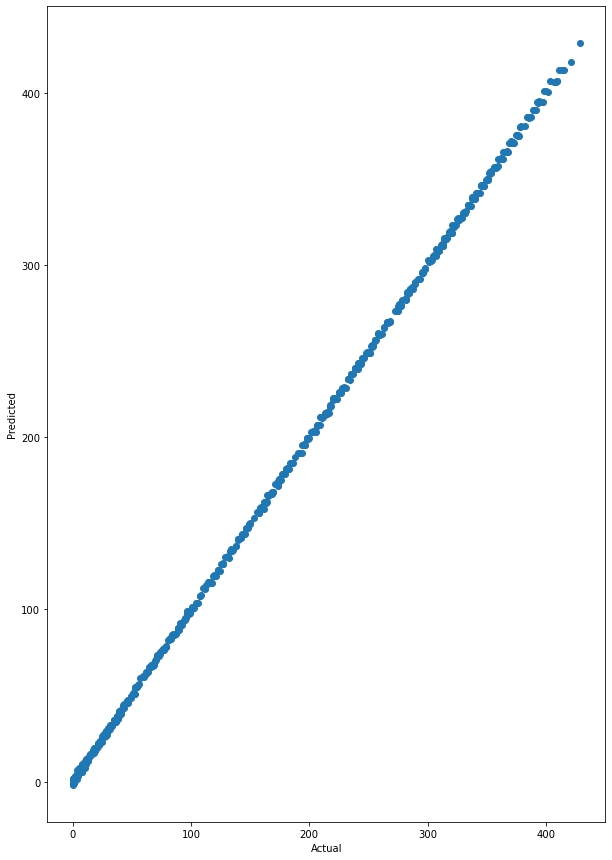

In [58]:
plt.figure(figsize = (10,15))
plt.scatter(Y_test, pred_val_optuna)
plt.xlabel('Actual')
plt.ylabel('Predicted')